In [1]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month 2w 3d


In [2]:
import kagglehub
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
from torch import optim
from sklearn.metrics import r2_score, explained_variance_score

In [3]:
torch.cuda.is_available()

True

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False


In [5]:
class ModelRegv0(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(ModelRegv0, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim + 10),
            nn.ReLU(),
            nn.Linear(self.input_dim + 10, self.input_dim + 10),
            nn.ReLU(),
            nn.Linear(self.input_dim + 10, self.input_dim),
            nn.ReLU(),
            nn.Linear(self.input_dim, self.input_dim // 2),
            nn.ReLU(),
            nn.Linear(self.input_dim // 2, self.output_dim)
        )
        
    def forward(self,x):
        out = self.layers(x)
        return out

In [6]:
class ModelRegv1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModelRegv1, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim * 2 + 2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.input_dim * 2 + 2, self.input_dim + 1),  # Исправлено
            nn.ReLU(),
            nn.BatchNorm1d(self.input_dim + 1),  # Исправлено
            nn.Linear(self.input_dim + 1, (self.input_dim + 1) // 2),
            nn.ReLU(),
            nn.Linear((self.input_dim + 1) // 2, self.output_dim)
        )
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [7]:
class ModelRegv2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModelRegv2, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim * 2),  # 31 -> 62
            nn.ReLU(),
            nn.BatchNorm1d(self.input_dim * 2),
            nn.Dropout(0.3),
            nn.Linear(self.input_dim * 2, self.input_dim),  # 62 -> 31
            nn.ReLU(),
            nn.BatchNorm1d(self.input_dim),
            nn.Dropout(0.3),
            nn.Linear(self.input_dim, self.input_dim // 2),  # 31 -> 15
            nn.ReLU(),
            nn.Linear(self.input_dim // 2, self.output_dim)  # 15 -> 1
        )
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [8]:
class ModelRegv3(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModelRegv3, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim * 3),  
            nn.ReLU(),
            nn.Linear(self.input_dim * 3, self.input_dim * 2),  
            nn.ReLU(),
            nn.Linear(self.input_dim * 2, self.input_dim + 32),  
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout перед уменьшением размерности
            nn.Linear(self.input_dim + 32, self.input_dim // 2 + 16),
            nn.ReLU(),
            nn.Linear(self.input_dim // 2 + 16, self.input_dim // 4 + 8),
            nn.ReLU(),
            nn.Linear(self.input_dim // 4 + 8, self.output_dim)  # Выходной слой
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
import torch.nn as nn

class ModelRegv4(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ModelRegv4, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layers = nn.Sequential(
            nn.Linear(self.input_dim, self.input_dim + 20),
            nn.ReLU(),
            nn.Linear(self.input_dim + 20, self.input_dim + 10),
            nn.ReLU(),
            nn.Linear(self.input_dim + 10, self.input_dim),
            nn.ReLU(),
            nn.Linear(self.input_dim, self.input_dim // 2),
            nn.ReLU(),
            nn.Linear(self.input_dim // 2, self.input_dim // 4),
            nn.ReLU(),
            nn.Linear(self.input_dim // 4, self.output_dim)
        )
        
    def forward(self, x):
        return self.layers(x)


/tmp/ipykernel_2165060/3326205373.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/rossman/train.csv')


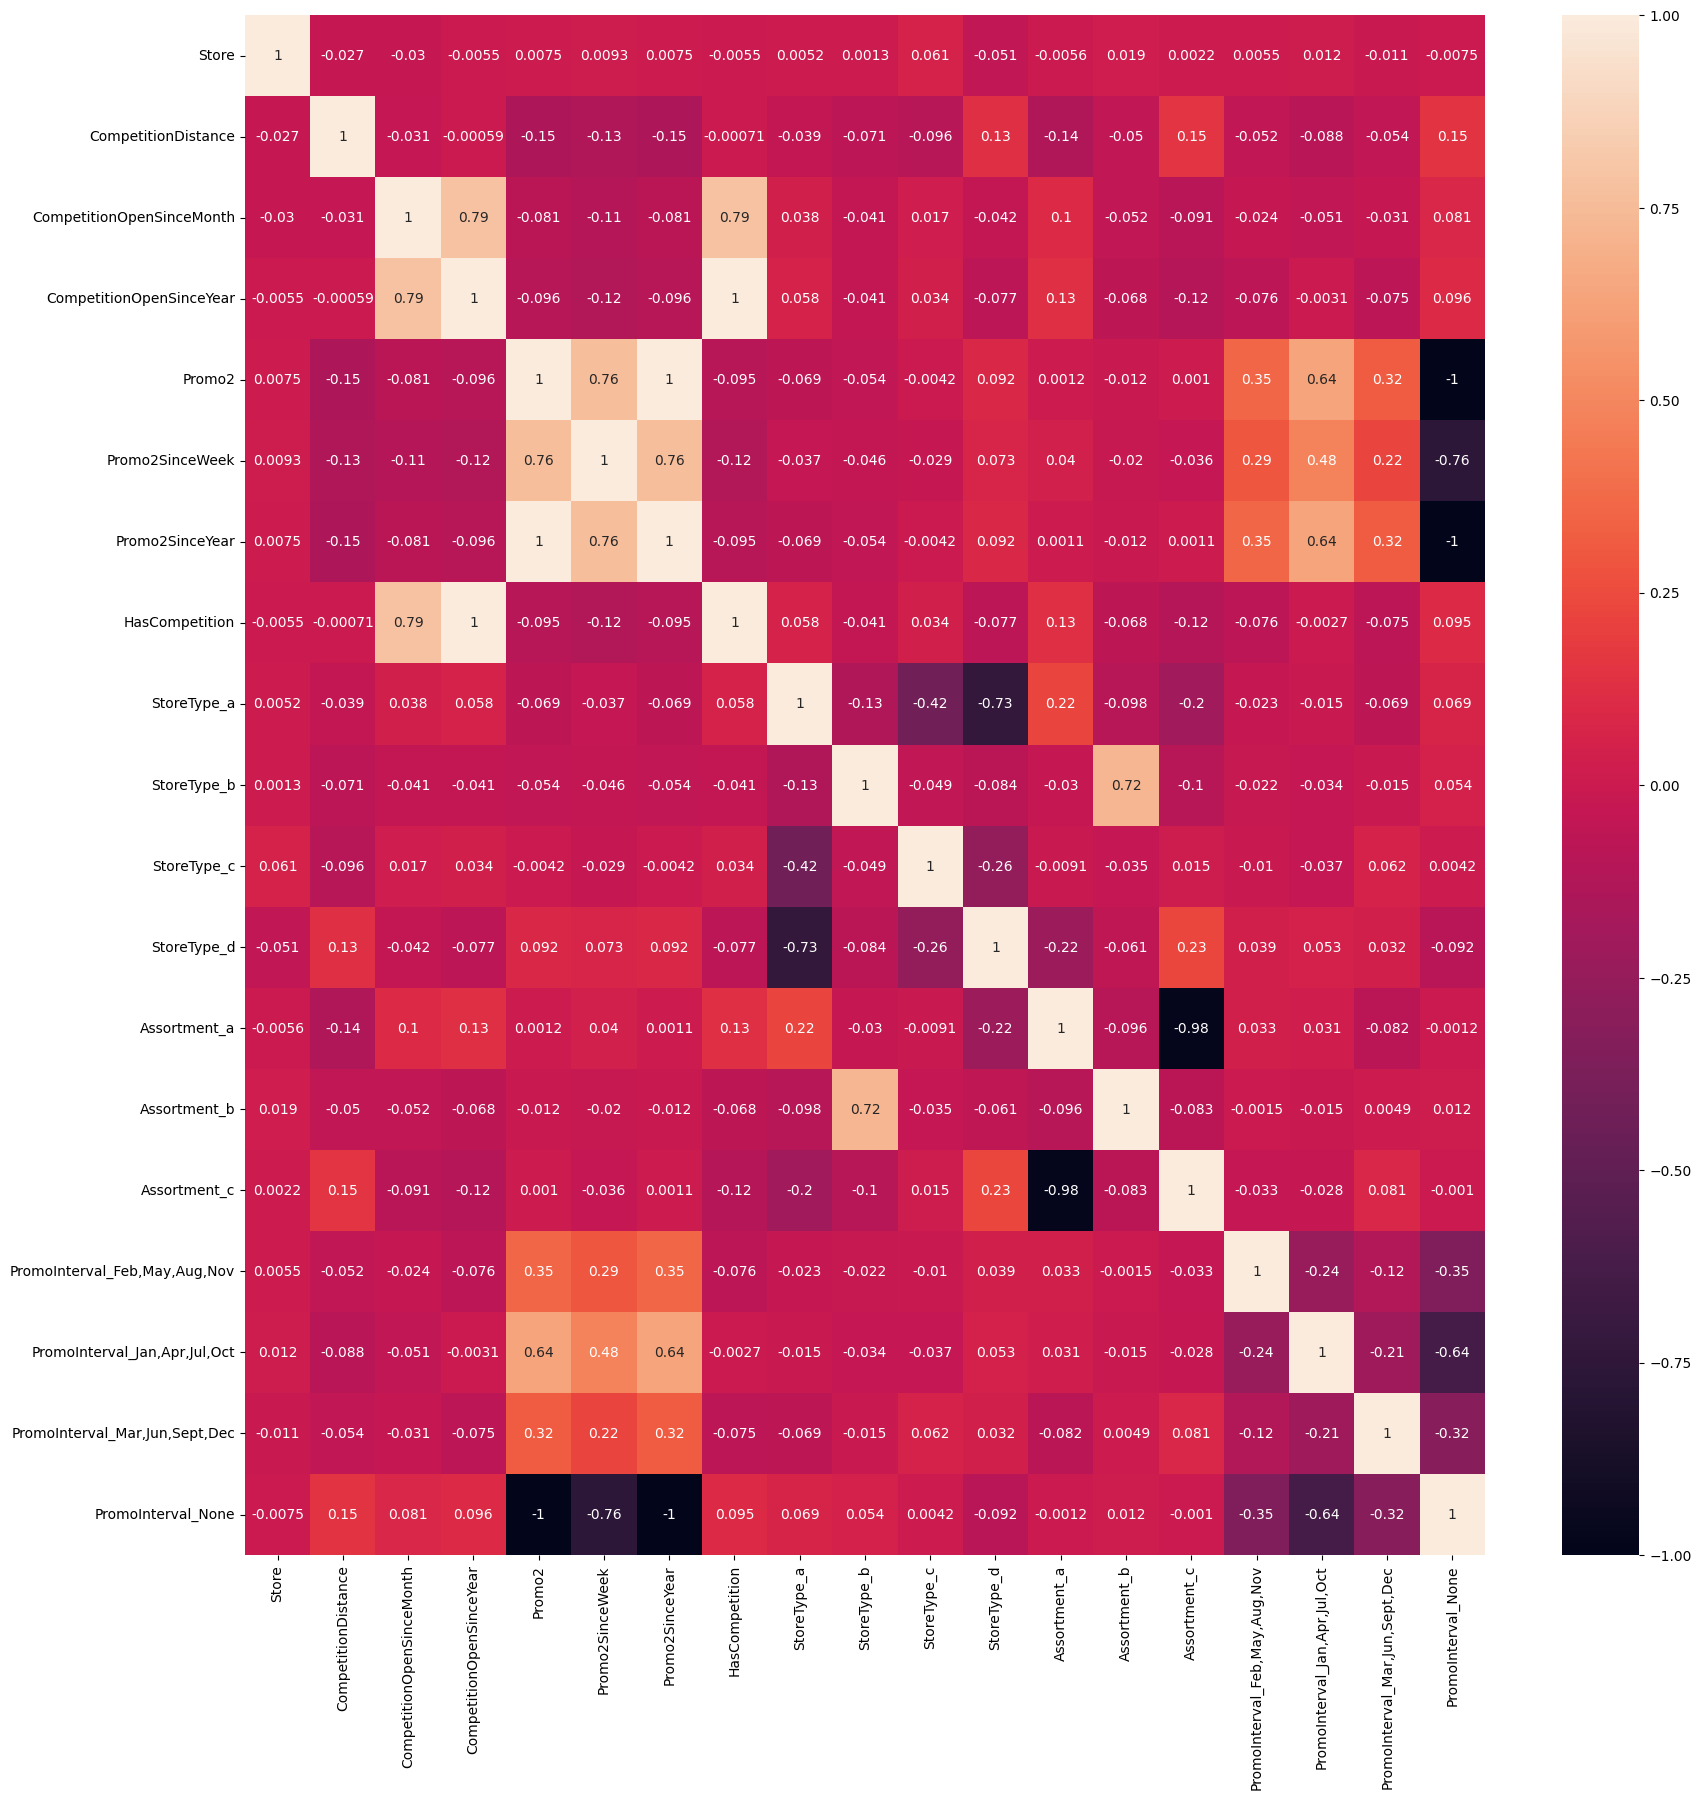

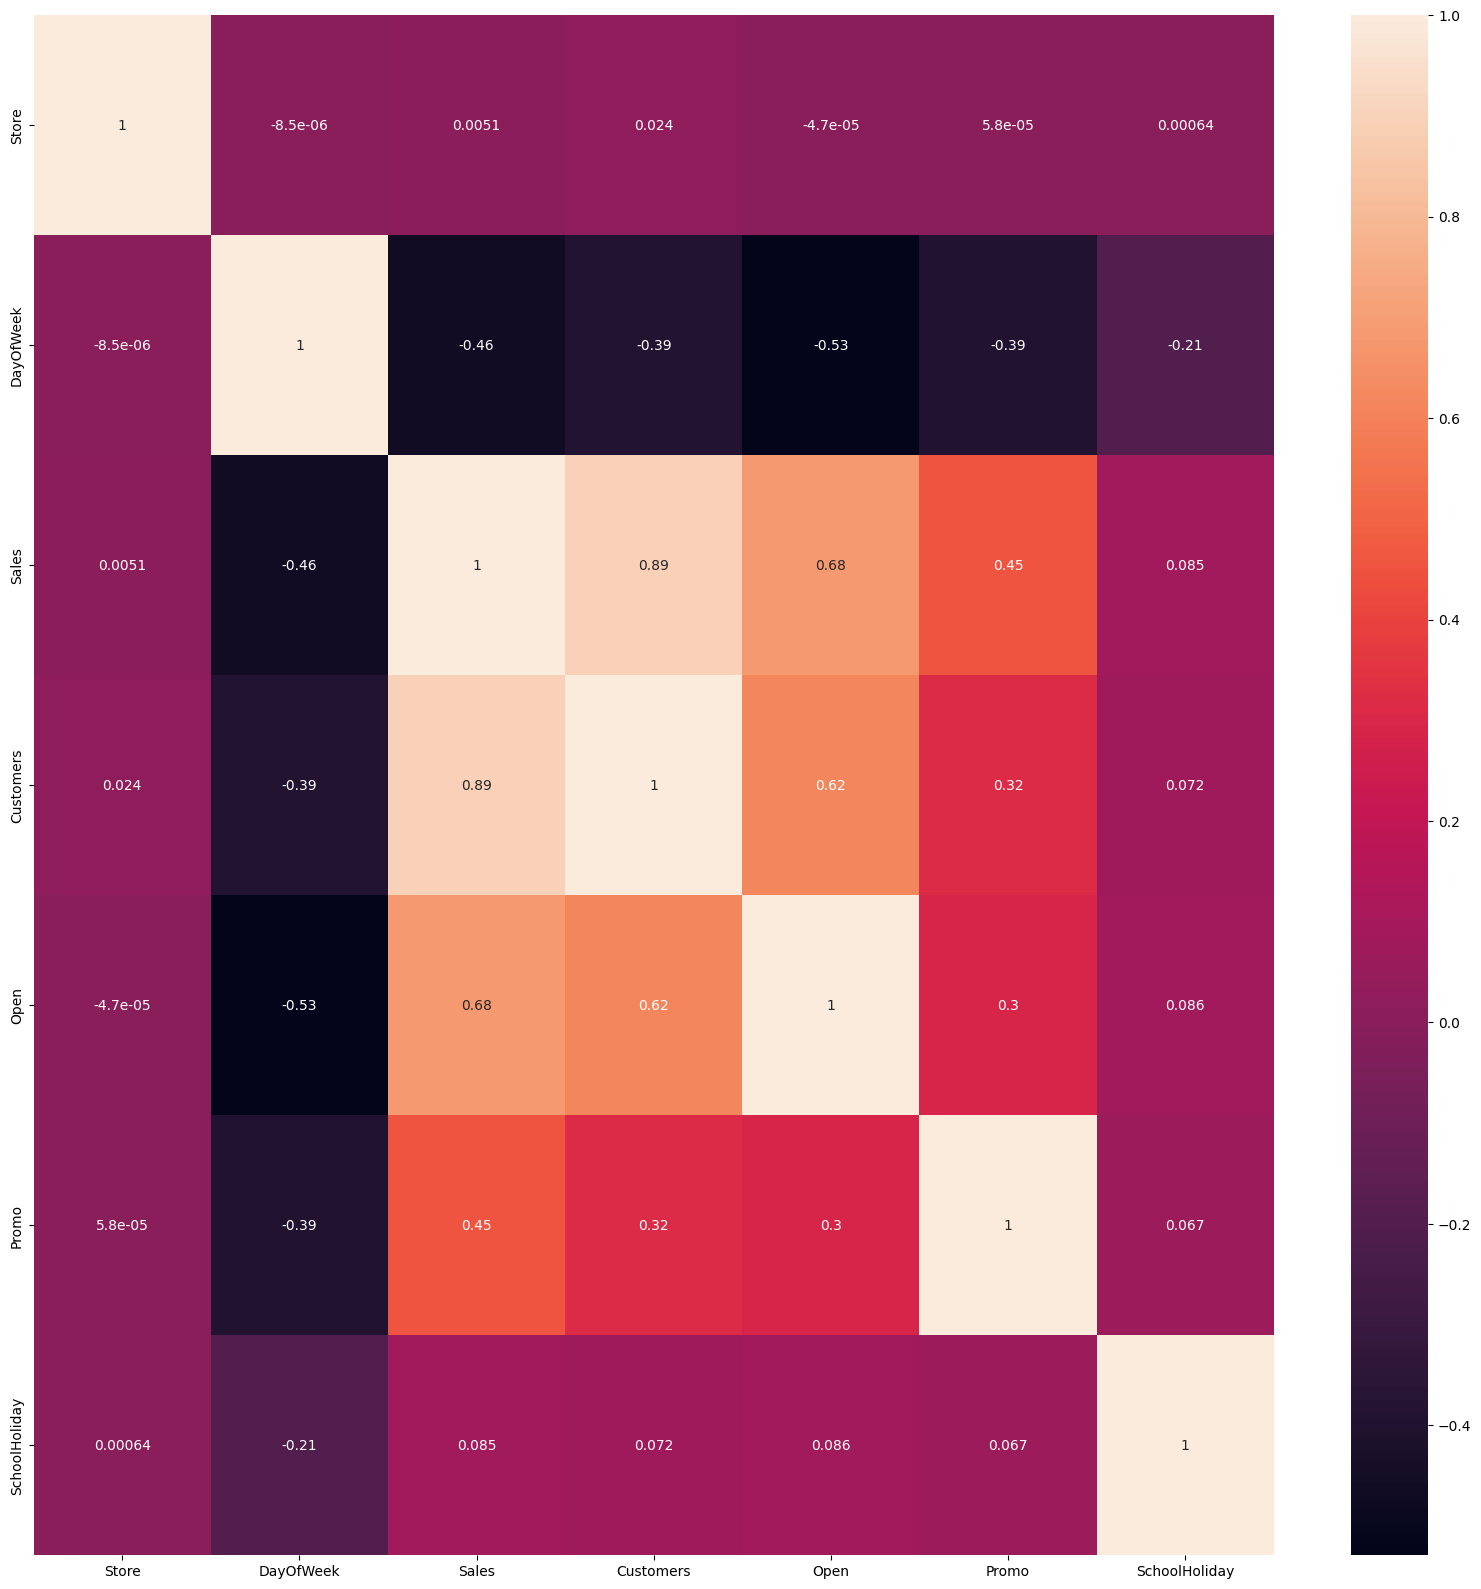

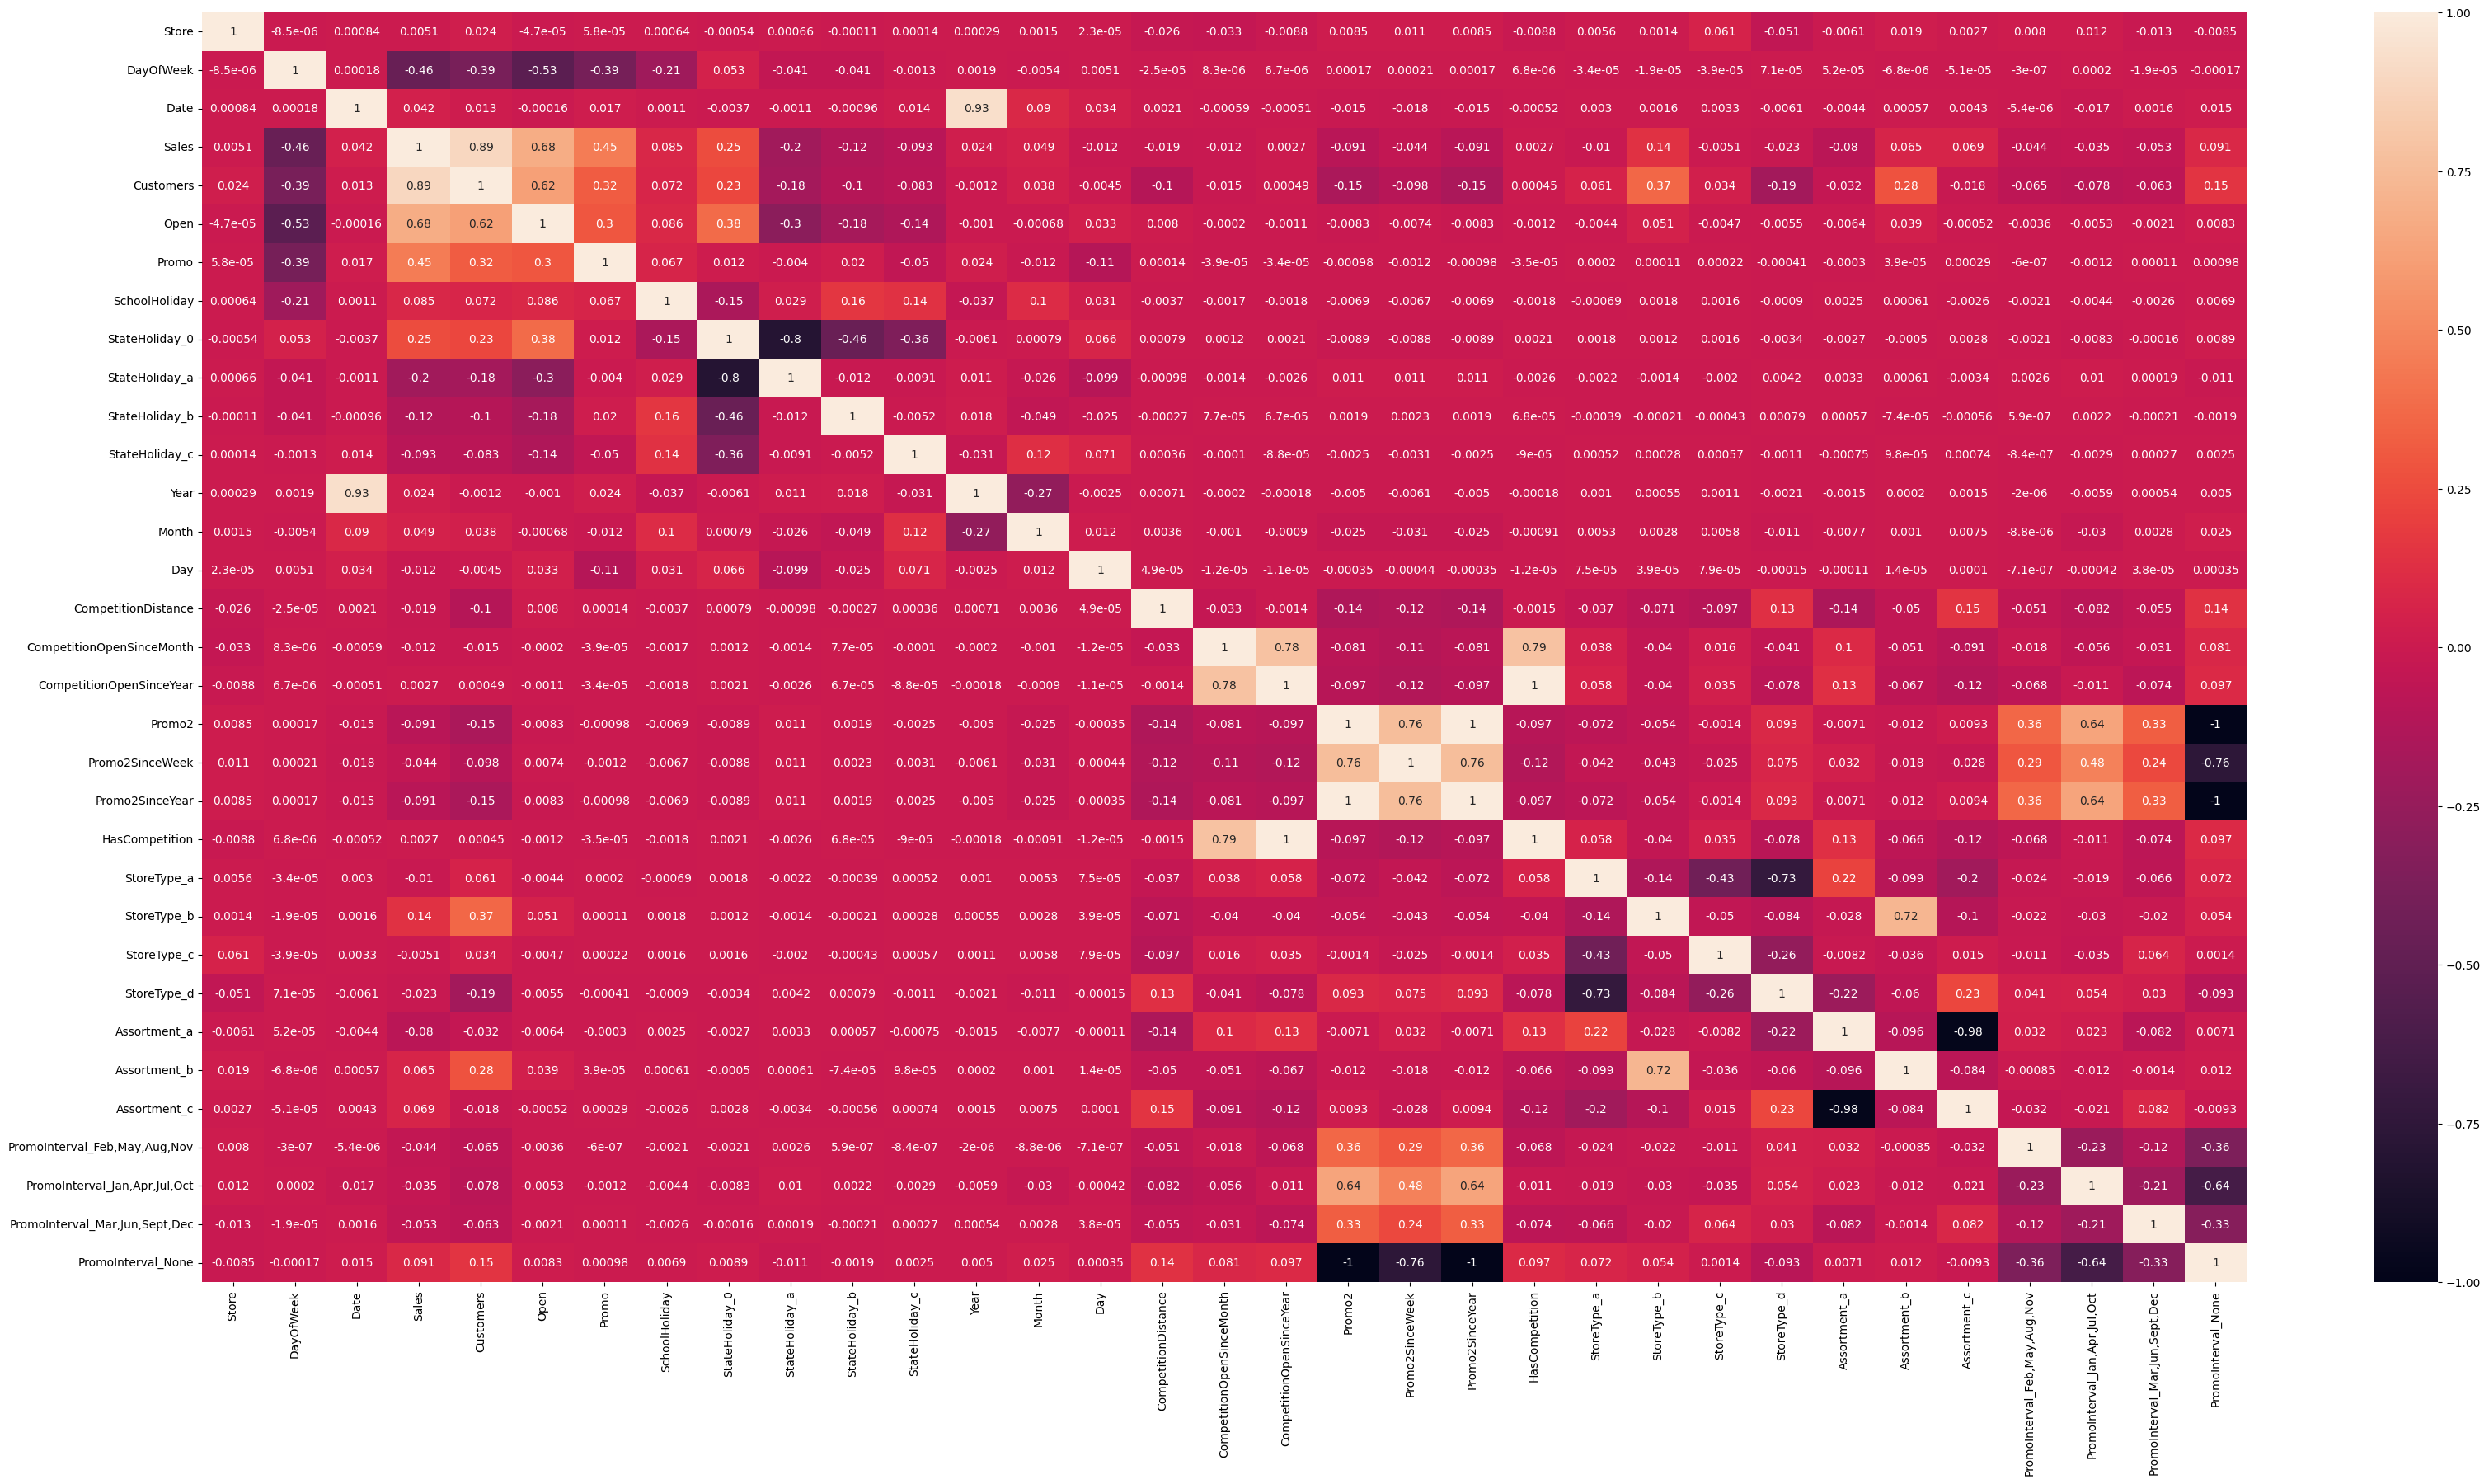

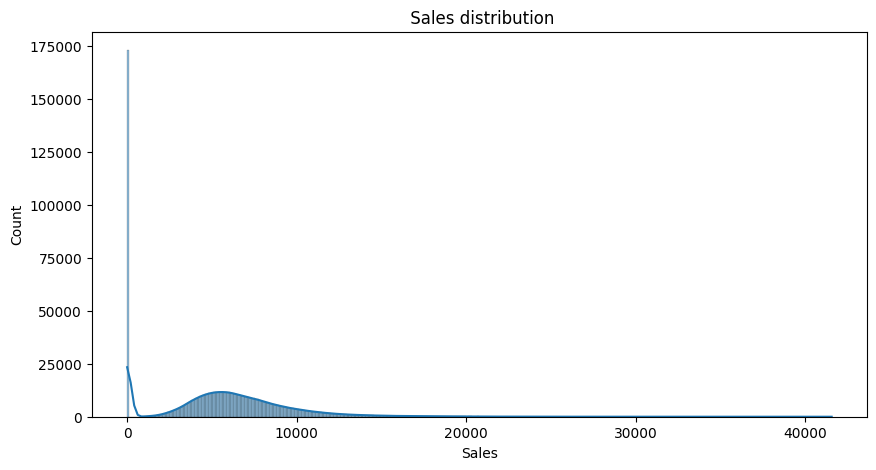

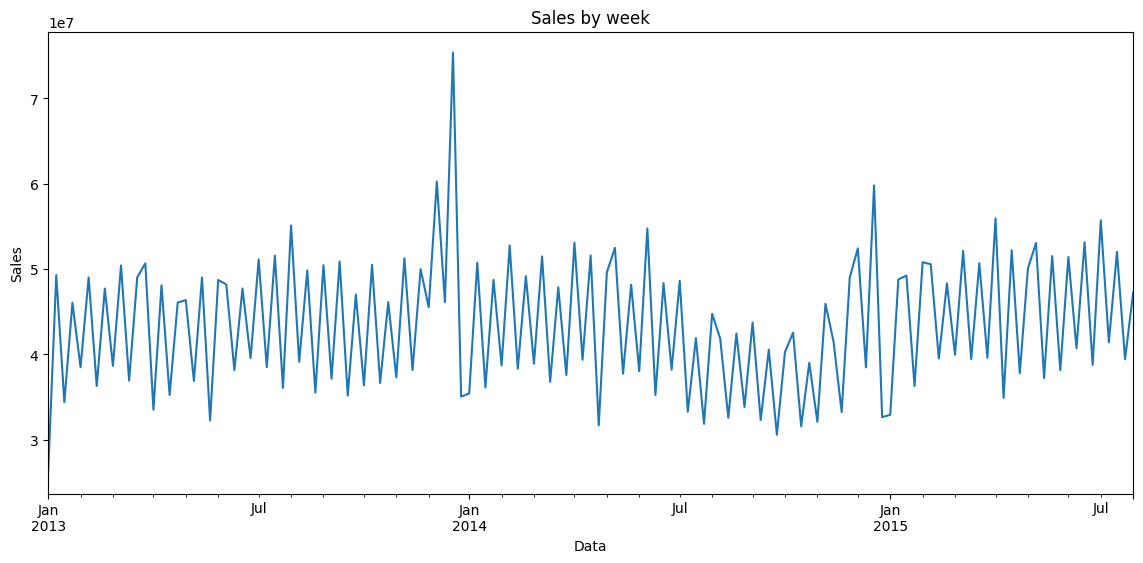

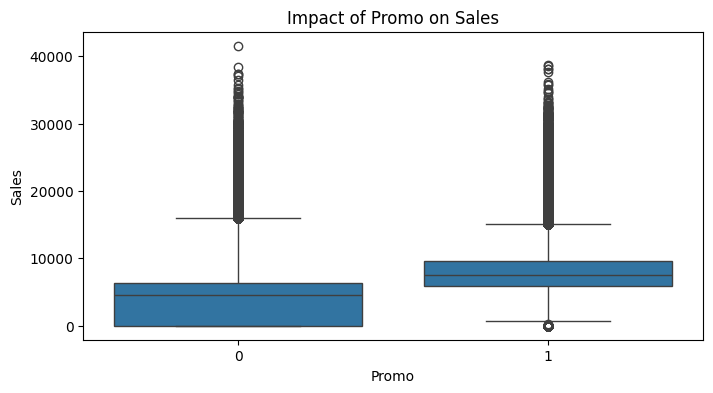

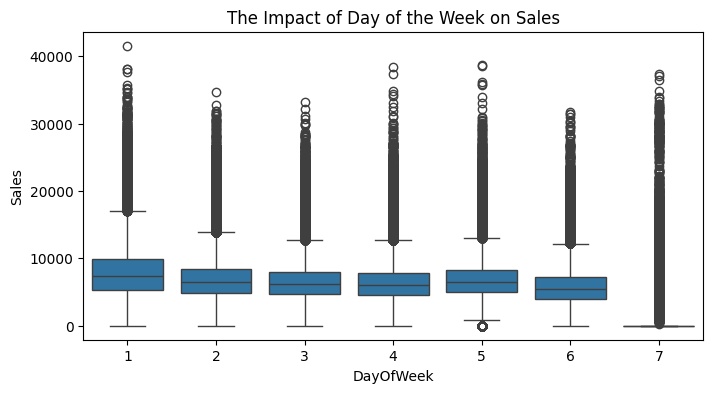

0
train_df (712046, 32)
test_df (152581, 32)
val_df (152582, 32)


In [9]:
 
#data
store_df = pd.read_csv('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/rossman/store.csv')
train_df = pd.read_csv('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/rossman/train.csv')

store_df['CompetitionDistance']= store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median())
store_df['CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(0)
store_df['CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(0)
store_df['HasCompetition'] = store_df['CompetitionOpenSinceMonth'] != 0
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(0)
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(0)
store_df['PromoInterval'] = store_df['PromoInterval'].fillna('None')

store_df = pd.get_dummies(store_df, columns=['StoreType', 'Assortment', 'PromoInterval'], prefix = ['StoreType', 'Assortment', 'PromoInterval'], dtype=int)
store_df['HasCompetition'] = store_df['HasCompetition'].astype(int)


fig,ax = plt.subplots(figsize = (20,20))
sns.heatmap(store_df.corr(), ax = ax, annot=True)
plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/store_df_corr.png')


fig,ax = plt.subplots(figsize = (20,20))
sns.heatmap(train_df.corr(numeric_only=True), ax = ax, annot=True)

plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/train_df_corr.png')

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.sort_values(by='Date')
train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)
train_df = pd.get_dummies(train_df, columns=['StateHoliday'], prefix=['StateHoliday'], dtype=int)

train_df['Year'] = train_df['Date'].dt.year.astype('int64')
train_df['Month'] = train_df['Date'].dt.month.astype('int64')
train_df['Day'] = train_df['Date'].dt.day.astype('int64')

merged_df = pd.merge(train_df, store_df, on='Store', how='left')

#EDA

fig,ax = plt.subplots(figsize = (40,20))
sns.heatmap(merged_df.corr(), ax = ax, annot=True)
plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/merged_df_corr.png')

# Sales
plt.figure(figsize=(10, 5))
sns.histplot(merged_df['Sales'], kde=True)
plt.title(' Sales distribution')
plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/Sales_distribution.png')

merged_df.set_index('Date', inplace=True)
plt.figure(figsize=(14, 6))
merged_df['Sales'].resample('W').sum().plot()
plt.title('Sales by week')
plt.xlabel('Data')
plt.ylabel('Sales')
plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/Sales_by_week.png')

train_df = train_df.drop('Date', axis=1)

plt.figure(figsize=(8, 4))
sns.boxplot(x='Promo', y='Sales', data=merged_df)
plt.title('Impact of Promo on Sales')
plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/Promo_on_Sales.png')


plt.figure(figsize=(8, 4))
sns.boxplot(x='DayOfWeek', y='Sales', data=merged_df.reset_index())
plt.title('The Impact of Day of the Week on Sales')
plt.savefig('/home/ir739wb/ilyarekun/nn-lessons/nn-o-task-hypr-testing/results/Day_on_Sales.png')

plt.show()

length = merged_df.shape[0]
train_len = int(length * 0.7)
test_len = int(length * 0.15)
val_len = length - train_len - test_len

print(length - train_len - test_len - val_len)

train_df = merged_df.iloc[0:train_len]
test_df = merged_df.iloc[train_len:train_len + test_len]
val_df = merged_df.iloc[train_len + test_len:]
print(f'train_df {train_df.shape}\ntest_df {test_df.shape}\nval_df {val_df.shape}')

y_train = train_df['Sales']
X_train = train_df.drop('Sales', axis=1)
y_test = test_df['Sales']
X_test = test_df.drop('Sales', axis=1)
y_val = val_df['Sales']
X_val = val_df.drop('Sales', axis=1)


scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X_train = torch.tensor(X_train,dtype=torch.float32)
X_test = torch.tensor(X_test,dtype=torch.float32)
X_val = torch.tensor(X_val,dtype=torch.float32)

y_train = torch.tensor(y_train.to_numpy(),dtype=torch.float32).reshape(-1,1)
y_test = torch.tensor(y_test.to_numpy(),dtype=torch.float32).reshape(-1,1)
y_val = torch.tensor(y_val.to_numpy(),dtype=torch.float32).reshape(-1,1)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



In [ ]:
merged_df.describe().to_csv("merged_df_description.csv")


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,...,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec",PromoInterval_None
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,...,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,9.694753e-01,1.991724e-02,6.576820e-03,...,1.556219e-02,1.345250e-01,3.076182e-01,5.283526e-01,8.153683e-03,4.634937e-01,1.165896e-01,2.881630e-01,9.581119e-02,4.994362e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,1.720261e-01,1.397160e-01,8.083051e-02,...,1.237741e-01,3.412156e-01,4.615078e-01,4.991957e-01,8.992891e-02,4.986658e-01,3.209308e-01,4.529076e-01,2.943323e-01,4.999999e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
print(np.isnan(X_train.numpy()).sum(), np.isinf(X_train.numpy()).sum())
print(np.isnan(y_train.numpy()).sum(), np.isinf(y_train.numpy()).sum())


0 0
0 0


In [ ]:
# Training loop 1
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
max_epochs = 100
learning_rate = 0.01
model = ModelRegv4(31, 1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Metrics
train_loss_metr = []
val_loss_metr = []
train_r2_metr = []
val_r2_metr = []
train_exp_var_metr = []
val_exp_var_metr = []

for epoch in range(max_epochs):
    
    model.train()
    train_loss = 0.0
    train_outputs = []
    train_targets = []
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        # saving
        train_outputs.append(output.cpu().detach().numpy())
        train_targets.append(target.cpu().detach().numpy())
    
    train_loss /= len(train_loader.dataset)
    
    # Concatenating for R² and Explained Variance
    train_outputs = np.concatenate(train_outputs)
    train_targets = np.concatenate(train_targets)
    train_r2 = r2_score(train_targets, train_outputs)
    train_exp_var = explained_variance_score(train_targets, train_outputs)
    
    model.eval()
    val_loss = 0.0
    val_outputs = []
    val_targets = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            
            # saving predictions and targets
            val_outputs.append(output.cpu().detach().numpy())
            val_targets.append(target.cpu().detach().numpy())
            
        val_loss /= len(val_loader.dataset)
        
        val_outputs = np.concatenate(val_outputs)
        val_targets = np.concatenate(val_targets)
        val_r2 = r2_score(val_targets, val_outputs)
        val_exp_var = explained_variance_score(val_targets, val_outputs)
    
    train_loss_metr.append(train_loss)
    val_loss_metr.append(val_loss)
    train_r2_metr.append(train_r2)
    val_r2_metr.append(val_r2)
    train_exp_var_metr.append(train_exp_var)
    val_exp_var_metr.append(val_exp_var)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train R²: {train_r2:.4f}, Val R²: {val_r2:.4f}, "
          f"Train ExpVar: {train_exp_var:.4f}, Val ExpVar: {val_exp_var:.4f}")
    print('\n')



Epoch 1: Train Loss: 1237118.5184, Val Loss: 2944735.1780, Train R²: 0.9140, Val R²: 0.8108, Train ExpVar: 0.9141, Val ExpVar: 0.9105


Epoch 2: Train Loss: 685962.4043, Val Loss: 3371998.4962, Train R²: 0.9523, Val R²: 0.7834, Train ExpVar: 0.9523, Val ExpVar: 0.9082


Epoch 3: Train Loss: 491769.1639, Val Loss: 2380966.4311, Train R²: 0.9658, Val R²: 0.8470, Train ExpVar: 0.9658, Val ExpVar: 0.9316


Epoch 4: Train Loss: 422555.9983, Val Loss: 2453321.7726, Train R²: 0.9706, Val R²: 0.8424, Train ExpVar: 0.9706, Val ExpVar: 0.9343


Epoch 5: Train Loss: 386605.2522, Val Loss: 3925506.8216, Train R²: 0.9731, Val R²: 0.7478, Train ExpVar: 0.9731, Val ExpVar: 0.9060


Epoch 6: Train Loss: 366606.9848, Val Loss: 2436885.9440, Train R²: 0.9745, Val R²: 0.8434, Train ExpVar: 0.9745, Val ExpVar: 0.9375


Epoch 7: Train Loss: 348634.9145, Val Loss: 2546439.8839, Train R²: 0.9758, Val R²: 0.8364, Train ExpVar: 0.9758, Val ExpVar: 0.9309


Epoch 8: Train Loss: 332624.1434, Val Loss: 2336802.90

KeyboardInterrupt: 

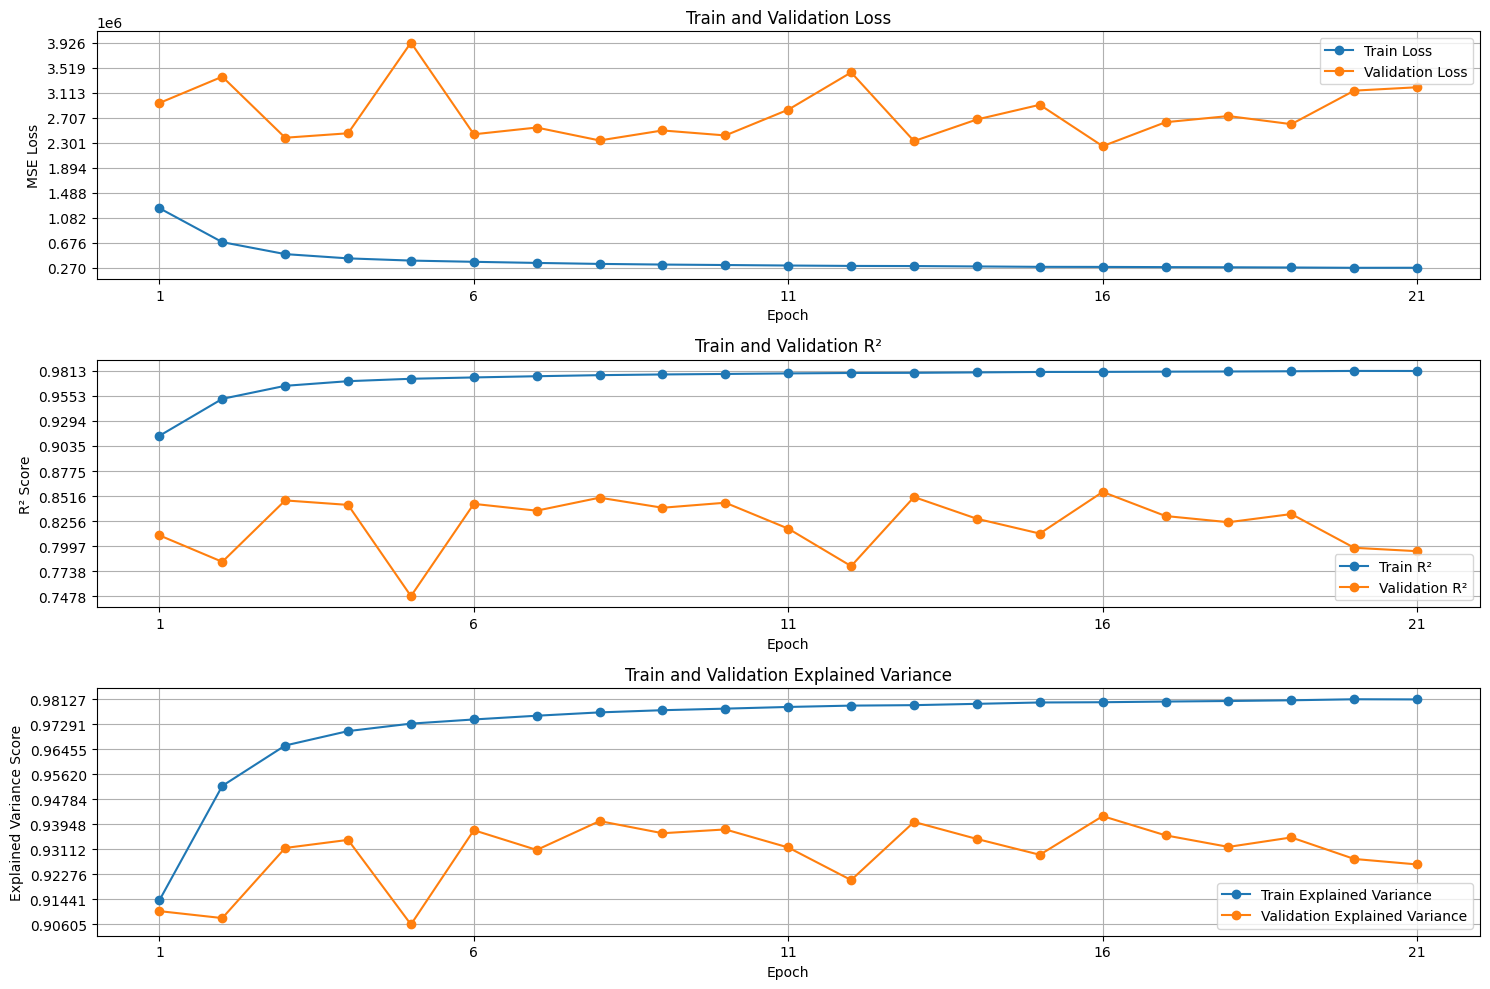

In [ ]:
# visualisation
epochs = range(1, len(train_loss_metr) + 1)

plt.figure(figsize=(15, 10))

# График Loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_loss_metr, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_metr, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.xticks(range(1, len(train_loss_metr) + 1, 5))  # Деления каждые 5 эпох
plt.yticks(np.linspace(min(min(train_loss_metr), min(val_loss_metr)), 
                       max(max(train_loss_metr), max(val_loss_metr)), 10))  # 10 делений по Y
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)

# График R²
plt.subplot(3, 1, 2)
plt.plot(epochs, train_r2_metr, label='Train R²', marker='o')
plt.plot(epochs, val_r2_metr, label='Validation R²', marker='o')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.xticks(range(1, len(train_loss_metr) + 1, 5))  # Деления каждые 5 эпох
plt.yticks(np.linspace(min(min(train_r2_metr), min(val_r2_metr)), 
                       max(max(train_r2_metr), max(val_r2_metr)), 10))  # 10 делений по Y
plt.title('Train and Validation R²')
plt.legend()
plt.grid(True)

# График Explained Variance
plt.subplot(3, 1, 3)
plt.plot(epochs, train_exp_var_metr, label='Train Explained Variance', marker='o')
plt.plot(epochs, val_exp_var_metr, label='Validation Explained Variance', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Explained Variance Score')
plt.xticks(range(1, len(train_loss_metr) + 1, 5))  # Деления каждые 5 эпох
plt.yticks(np.linspace(min(min(train_exp_var_metr), min(val_exp_var_metr)), 
                       max(max(train_exp_var_metr), max(val_exp_var_metr)), 10))  # 10 делений по Y
plt.title('Train and Validation Explained Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('./nn-o-task-hypr-testing/results/metrics_v4.png')
plt.show()